# Claude Random Number Picker

Inspired by this [Information is Beautiful viz on what random number ChatGPT guesses](https://twitter.com/infobeautiful/status/1778059112250589561), I tried the same with Claude 3 Haiku.

In [1]:
import os

api_key = os.environ.get("ANTHROPIC_API_KEY")

In [28]:
import os
import json
import httpx


# If we have prior cached data, load it
data = {}
if os.path.exists("claude-random.json"):
    with open("claude-random.json", "r") as f:
        data = json.load(f)

for attempt in range(0, 200):
    for t in range(100, -1, -10):
        temperature = t / 100
        key = f"T={temperature:.2f},#{attempt}"
        if key in data:
            continue
        r = httpx.post("https://api.anthropic.com/v1/messages", headers={
            "x-api-key": api_key,
            "anthropic-version": "2023-06-01",
            "content-type": "application/json",
        }, json={
          "model": "claude-3-haiku-20240307",
          "max_tokens": 2,
          "temperature": temperature,
          "messages": [
              {"role": "user", "content": "Pick a random number from 0 - 100. Write ONLY the number NOTHING ELSE"}
          ]
        })
        r.raise_for_status()
        data[key] = r.json()["content"][0]["text"]
        with open("claude-random.json", "w") as f:
            json.dump(data, f, sort_keys=True)

In [29]:
# Convert data into a Pandas DataFrame with columns "t" (for temperature), "#" for attempt, and "n" for the random number
import pandas as pd
df = pd.DataFrame([{"t": float(k.split(",")[0].split("=")[1]), "#": int(k.split("#")[1]), "n": int(v)} for k, v in data.items()])
df

,t,#,n
0,0.0,0,42
1,0.0,1,42
2,0.0,10,42
3,0.0,11,42
4,0.0,12,42
...,...,...,...
2195,0.4,199,72
2196,0.3,199,47
2197,0.2,199,42
2198,0.1,199,42


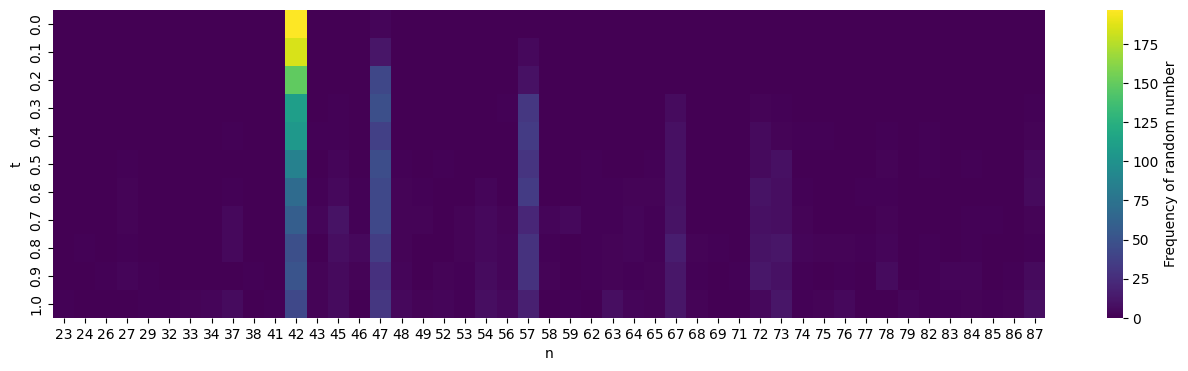

In [30]:
# Draw a heatmap of the random numbers. X-axis is the random number n, Y-axis is the temperature t, and the color is the frequency of that random number at that temperature.
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
pivot = df.pivot_table(index="t", columns="n", values="#", aggfunc="count").fillna(0)
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Frequency of random number'})
plt.show()

In [33]:
df['n'].value_counts()

42    1099
47     365
57     236
67      81
72      56
73      56
45      37
87      27
54      24
37      16
78      15
48      14
63      13
56      13
64      12
74       9
43       9
65       9
27       9
84       8
46       8
76       7
52       6
58       6
53       6
59       5
62       5
49       5
75       5
68       5
82       5
83       4
86       3
34       3
79       3
77       2
29       2
33       2
85       2
26       1
71       1
69       1
32       1
41       1
23       1
38       1
24       1
Name: n, dtype: int64

Claude 3 Haiku

- Clearly prefers 42!
- Guesses numbers in a much smaller range (23-87) compared to OpenAI.
- Prefers numbers ending with 7: 37, 47, 57, 67, also 27, 87, but not 77.
- Prefers multiples of 9: 72, 45, 54, 63 are pretty popular.